In [195]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import svd
from numpy.linalg import lstsq
from scipy.optimize import minimize , least_squares
import math
from scipy.integrate import cumulative_trapezoid, trapezoid, simpson, cumulative_simpson, romb
from scipy import signal
from scipy.stats import linregress
from scipy.ndimage import gaussian_filter1d  # For smoothing bias corrections
from scipy.interpolate import CubicSpline

In [196]:

# Load the JSON files
with open('gps_data_donut.json', 'r') as f1, open('imu_data_donut.json', 'r') as f2, open('gps_data_tour.json', 'r') as f3, open('imu_data_tour.json', 'r') as f4:
    gps_data_cal = json.load(f1)
    imu_data_cal = json.load(f2)
    gps_data = json.load(f3)
    imu_data = json.load(f4)

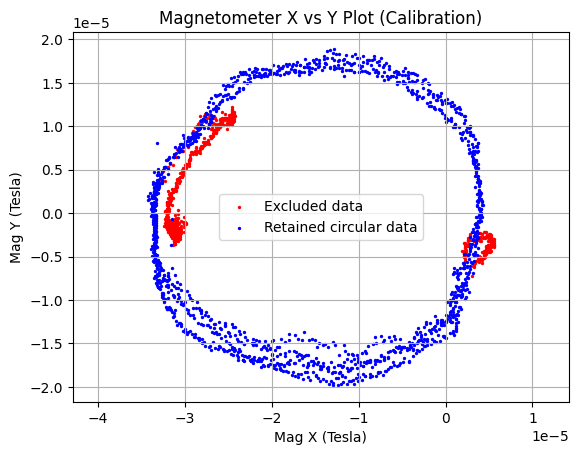

In [197]:
mag_x_cal = np.asarray([entry['mag_x'] for entry in imu_data_cal][900:2400])
mag_y_cal = np.asarray([entry['mag_y'] for entry in imu_data_cal][900:2400])

# Get the data outside the 900 to 2400 range
mag_x_outside = np.asarray([entry['mag_x'] for entry in imu_data_cal][:900] + [entry['mag_x'] for entry in imu_data_cal][2400:])
mag_y_outside = np.asarray([entry['mag_y'] for entry in imu_data_cal][:900] + [entry['mag_y'] for entry in imu_data_cal][2400:])

# Plot the data
plt.figure()
plt.scatter(mag_x_outside, mag_y_outside, color='red', label='Excluded data', s=2)
plt.scatter(mag_x_cal, mag_y_cal, color='blue', label='Retained circular data', s=2)

# Add labels, title, legend, and grid
plt.xlabel('Mag X (Tesla)')
plt.ylabel('Mag Y (Tesla)')
plt.title('Magnetometer X vs Y Plot (Calibration)')
plt.legend()
plt.axis('equal')
plt.grid(True)

plt.savefig("mag_raw.png", format="png")




Exact parameters:
Fitted parameters:
a, b, c, d, e, f = [ 6.54826330e-01 -5.34597765e-02  7.53886285e-01  1.88753836e-05
 -1.89930602e-07 -9.97718675e-11]
x0, y0, ap, bp, e, phi =  -1.4428251404761427e-05 -3.856022492136095e-07 1.907901561761243e-05 1.761079805099483e-05 0.3846909748477651 0.2474392196831942


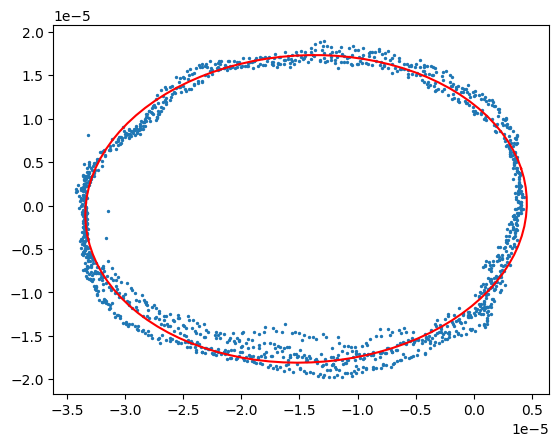

In [198]:
def fit_ellipse(x, y):
    """

    Fit the coefficients a,b,c,d,e,f, representing an ellipse described by
    the formula F(x,y) = ax^2 + bxy + cy^2 + dx + ey + f = 0 to the provided
    arrays of data points x=[x1, x2, ..., xn] and y=[y1, y2, ..., yn].

    Based on the algorithm of Halir and Flusser, "Numerically stable direct
    least squares fitting of ellipses'.


    """

    D1 = np.vstack([x**2, x*y, y**2]).T
    D2 = np.vstack([x, y, np.ones(len(x))]).T
    S1 = D1.T @ D1
    S2 = D1.T @ D2
    S3 = D2.T @ D2
    T = -np.linalg.inv(S3) @ S2.T
    M = S1 + S2 @ T
    C = np.array(((0, 0, 2), (0, -1, 0), (2, 0, 0)), dtype=float)
    M = np.linalg.inv(C) @ M
    eigval, eigvec = np.linalg.eig(M)
    con = 4 * eigvec[0]* eigvec[2] - eigvec[1]**2
    ak = eigvec[:, np.nonzero(con > 0)[0]]
    return np.concatenate((ak, T @ ak)).ravel()


def cart_to_pol(coeffs):
    """

    Convert the cartesian conic coefficients, (a, b, c, d, e, f), to the
    ellipse parameters, where F(x, y) = ax^2 + bxy + cy^2 + dx + ey + f = 0.
    The returned parameters are x0, y0, ap, bp, e, phi, where (x0, y0) is the
    ellipse centre; (ap, bp) are the semi-major and semi-minor axes,
    respectively; e is the eccentricity; and phi is the rotation of the semi-
    major axis from the x-axis.

    """

    # We use the formulas from https://mathworld.wolfram.com/Ellipse.html
    # which assumes a cartesian form ax^2 + 2bxy + cy^2 + 2dx + 2fy + g = 0.
    # Therefore, rename and scale b, d and f appropriately.
    a = coeffs[0]
    b = coeffs[1] / 2
    c = coeffs[2]
    d = coeffs[3] / 2
    f = coeffs[4] / 2
    g = coeffs[5]

    den = b**2 - a*c
    if den > 0:
        raise ValueError('coeffs do not represent an ellipse: b^2 - 4ac must'
                         ' be negative!')

    # The location of the ellipse centre.
    x0, y0 = (c*d - b*f) / den, (a*f - b*d) / den

    num = 2 * (a*f**2 + c*d**2 + g*b**2 - 2*b*d*f - a*c*g)
    fac = np.sqrt((a - c)**2 + 4*b**2)
    # The semi-major and semi-minor axis lengths (these are not sorted).
    ap = np.sqrt(num / den / (fac - a - c))
    bp = np.sqrt(num / den / (-fac - a - c))

    # Sort the semi-major and semi-minor axis lengths but keep track of
    # the original relative magnitudes of width and height.
    width_gt_height = True
    if ap < bp:
        width_gt_height = False
        ap, bp = bp, ap

    # The eccentricity.
    r = (bp/ap)**2
    if r > 1:
        r = 1/r
    e = np.sqrt(1 - r)

    # The angle of anticlockwise rotation of the major-axis from x-axis.
    if b == 0:
        phi = 0 if a < c else np.pi/2
    else:
        phi = np.arctan((2.*b) / (a - c)) / 2
        if a > c:
            phi += np.pi/2
    if not width_gt_height:
        # Ensure that phi is the angle to rotate to the semi-major axis.
        phi += np.pi/2
    phi = phi % np.pi

    return x0, y0, ap, bp, e, phi


def get_ellipse_pts(params, npts=100, tmin=0, tmax=2*np.pi):
    """
    Return npts points on the ellipse described by the params = x0, y0, ap,
    bp, e, phi for values of the parametric variable t between tmin and tmax.

    """

    x0, y0, ap, bp, e, phi = params
    # A grid of the parametric variable, t.
    t = np.linspace(tmin, tmax, npts)
    x = x0 + ap * np.cos(t) * np.cos(phi) - bp * np.sin(t) * np.sin(phi)
    y = y0 + ap * np.cos(t) * np.sin(phi) + bp * np.sin(t) * np.cos(phi)
    return x, y


if __name__ == '__main__':

    x = mag_x_cal
    y = mag_y_cal

    coeffs = fit_ellipse(x, y)
    print('Exact parameters:')
    # print('x0, y0, ap, bp, phi =', x0, y0, ap, bp, phi)
    print('Fitted parameters:')
    print('a, b, c, d, e, f =', coeffs)
    x0, y0, ap, bp, e, phi = cart_to_pol(coeffs)
    print('x0, y0, ap, bp, e, phi = ', x0, y0, ap, bp, e, phi)

    plt.scatter(x, y,s=2)     # given points
    x, y = get_ellipse_pts((x0, y0, ap, bp, e, phi))
    plt.plot(x, y,c='red')
    plt.show()


Magnetic field correction function

In [199]:

def mag_correction(mag_x,mag_y):
    x0, y0, ap, bp, e, phi =  -1.4428251404761427e-05 ,-3.856022492136095e-07, 1.907901561761243e-05 ,1.761079805099483e-05, 0.3846909748477651,0.2474392196831942
    x_shifted = mag_x - x0
    y_shifted = mag_y - y0

    x_rotated = np.cos(-phi) * x_shifted - np.sin(-phi) * y_shifted
    y_rotated = np.sin(-phi) * x_shifted + np.cos(-phi) * y_shifted

    x_corrected = x_rotated / ap
    y_corrected = y_rotated / bp

    scale_factor = np.sqrt(ap * bp)

    x_scaled = x_corrected * scale_factor
    y_scaled = y_corrected * scale_factor

    x_final = np.cos(phi) * x_scaled - np.sin(phi) * y_scaled
    y_final = np.sin(phi) * x_scaled + np.cos(phi) * y_scaled

    return x_final,y_final


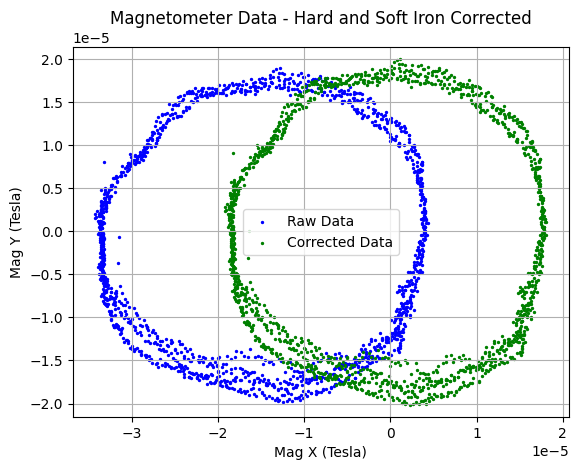

In [200]:

mag_x_corrected,mag_y_corrected = mag_correction(mag_x_cal,mag_y_cal)

plt.figure()
plt.scatter(mag_x_cal, mag_y_cal, c='blue', label='Raw Data',s=2)
plt.scatter(mag_x_corrected, mag_y_corrected, c='green', label='Corrected Data',s=2)

plt.xlabel('Mag X (Tesla)')
plt.ylabel('Mag Y (Tesla)')
plt.title('Magnetometer Data - Hard and Soft Iron Corrected')

plt.grid(True)
plt.axis('equal')
plt.legend()

plt.savefig("mag_cal.png", format="png")


checking how good the correction is (spoiler: its really good)

Exact parameters:
Fitted parameters:
a, b, c, d, e, f = [ 7.07106781e-01 -1.05666092e-16  7.07106781e-01 -7.79772996e-21
  3.42444677e-20 -2.37585539e-10]
x0, y0, ap, bp, e, phi =  5.5138277336374285e-21 -2.4214495355995714e-20 1.8330212520686974e-05 1.8330212520686906e-05 8.560065398421926e-08 0.010123675319516452


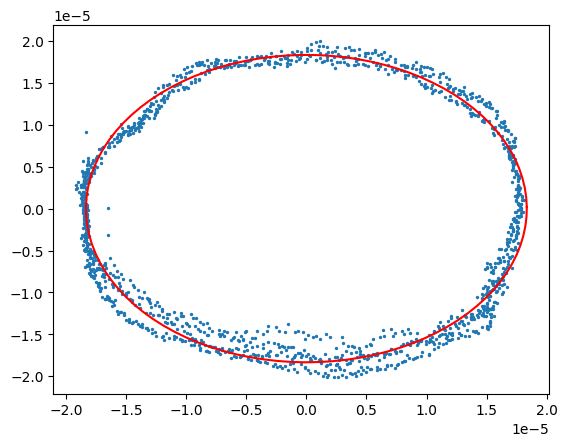

In [201]:
x = mag_x_corrected
y = mag_y_corrected

coeffs = fit_ellipse(x, y)
print('Exact parameters:')
# print('x0, y0, ap, bp, phi =', x0, y0, ap, bp, phi)
print('Fitted parameters:')
print('a, b, c, d, e, f =', coeffs)
x0, y0, ap, bp, e, phi = cart_to_pol(coeffs)
print('x0, y0, ap, bp, e, phi = ', x0, y0, ap, bp, e, phi)

plt.scatter(x, y,s=2)     # given points
x, y = get_ellipse_pts((x0, y0, ap, bp, e, phi))
plt.plot(x, y,c='red')
plt.show()

# Sensor fusion

In [202]:
imu_timestamps = np.array([entry['timestamp'] for entry in imu_data]) 

yaws = np.array([entry['yaw'] for entry in imu_data])
pitches = np.array([entry['pitch'] for entry in imu_data])
rolls = np.array([entry['roll'] for entry in imu_data])

mag_x = np.array([entry['mag_x'] for entry in imu_data])
mag_y = np.array([entry['mag_y'] for entry in imu_data])
mag_z = np.array([entry['mag_z'] for entry in imu_data])

accel_x = np.array([entry['accel_x'] for entry in imu_data])
accel_y = np.array([entry['accel_y'] for entry in imu_data])
accel_z = np.array([entry['accel_z'] for entry in imu_data])

gyro_x = np.array([entry['gyro_x'] for entry in imu_data])
gyro_y = np.array([entry['gyro_y'] for entry in imu_data])
gyro_z = np.array([entry['gyro_z'] for entry in imu_data])

utm_easting = np.array([entry['utm_easting'] for entry in gps_data])
utm_northing = np.array([entry['utm_northing'] for entry in gps_data])
gps_timestamps = np.array([entry['timestamp'] for entry in gps_data]) - np.array([imu_timestamps[0]] * len(gps_data))
imu_timestamps = imu_timestamps - np.array([imu_timestamps[0]] * len(imu_data))

# print(mag_x)
print(gps_timestamps)
print(imu_timestamps)


[3.10796976e-01 1.30796814e+00 2.30588722e+00 3.30568981e+00
 4.31065679e+00 5.30873895e+00 6.30578804e+00 7.31168222e+00
 8.30496597e+00 9.30676150e+00 1.03081994e+01 1.13149416e+01
 1.23123858e+01 1.33125339e+01 1.43058369e+01 1.53060927e+01
 1.63093064e+01 1.73067811e+01 1.83083971e+01 1.93146117e+01
 2.03115544e+01 2.13139162e+01 2.23118794e+01 2.33097346e+01
 2.43063257e+01 2.53085060e+01 2.63109190e+01 2.73073049e+01
 2.83127606e+01 2.93058350e+01 3.03082263e+01 3.13089023e+01
 3.23136582e+01 3.33119950e+01 3.43127484e+01 3.53085153e+01
 3.63058324e+01 3.73066790e+01 3.83068376e+01 3.93067033e+01
 4.03119066e+01 4.13132861e+01 4.23125610e+01 4.33118968e+01
 4.43076584e+01 4.53062599e+01 4.63067043e+01 4.73123300e+01
 4.83058667e+01 4.93098497e+01 5.03134632e+01 5.13085728e+01
 5.23080380e+01 5.33095829e+01 5.43081141e+01 5.53092725e+01
 5.63077528e+01 5.73129058e+01 5.83130333e+01 5.93134637e+01
 6.03075316e+01 6.13159187e+01 6.23133957e+01 6.33133414e+01
 6.43130639e+01 6.530950

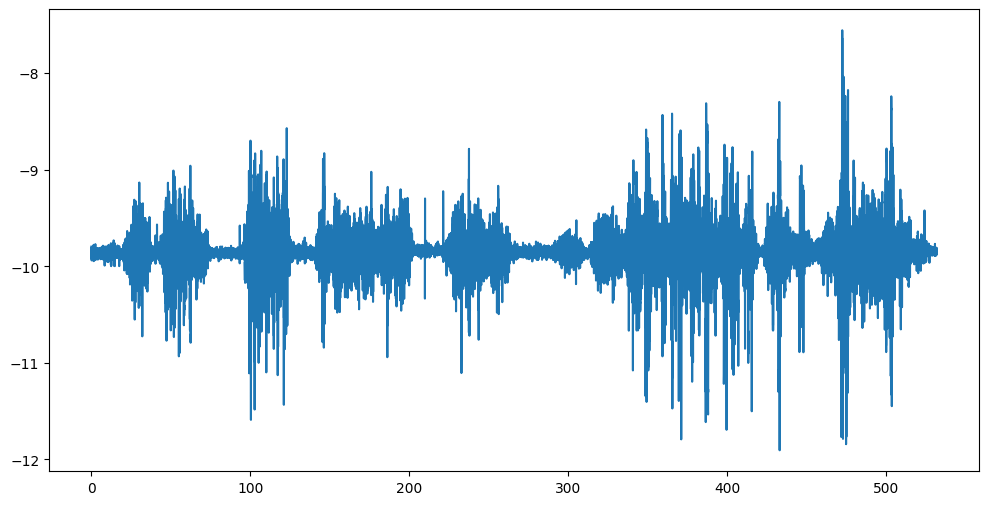

In [203]:
plt.figure(figsize=(12, 6))
plt.plot(imu_timestamps,accel_z)
plt.show()


In [204]:

# plt.figure(figsize=(12, 6))
# plt.plot(imu_timestamps,filtered_accel_x)
# plt.show()

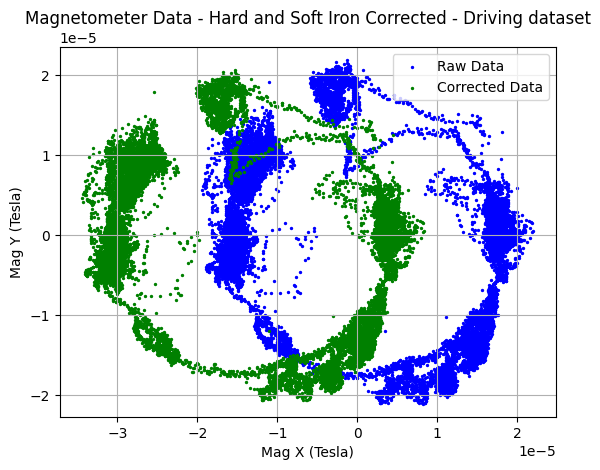

In [205]:
mag_x_corrected, mag_y_corrected = mag_correction(mag_x,mag_y)
plt.figure()
plt.scatter(mag_x_corrected, mag_y_corrected, c='blue', label='Raw Data',s=2)
plt.scatter(mag_x, mag_y, c='green', label='Corrected Data',s=2)

plt.xlabel('Mag X (Tesla)')
plt.ylabel('Mag Y (Tesla)')
plt.title('Magnetometer Data - Hard and Soft Iron Corrected - Driving dataset')

plt.grid(True)
plt.axis('equal')
plt.legend()

plt.savefig("mag_cal_actual.png", format="png")

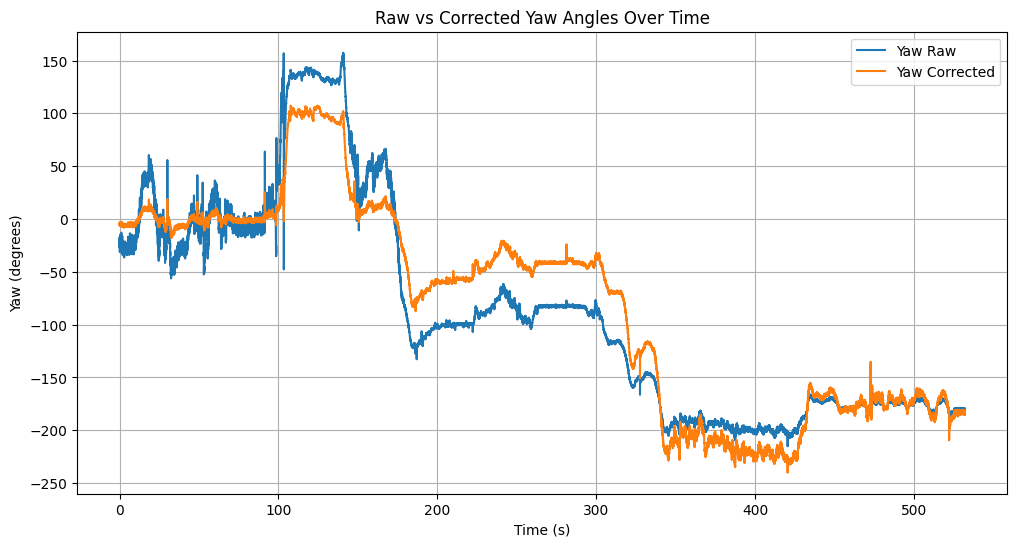

In [206]:
yaw_raw = np.atan2(mag_y,mag_x)
yaw_corrected = np.atan2(mag_y_corrected,mag_x_corrected)

def maintain_continuous_yaw(yaw_values):
    continuous_yaw = np.zeros_like(yaw_values)
    continuous_yaw[0] = yaw_values[0]  # Initialize the first value
    
    for i in range(1, len(yaw_values)):
        diff = yaw_values[i] - continuous_yaw[i-1]
        
        # Adjust the difference to handle wrapping
        if diff > 180:
            diff -= 360
        elif diff < -180:
            diff += 360
        
        continuous_yaw[i] = continuous_yaw[i-1] + diff

    return continuous_yaw

def calculate_heading(x, y):
    headings = []
    for i in range(1, len(x)):
        delta_x = x[i] - x[i - 1]
        delta_y = y[i] - y[i - 1]
        angle = math.atan2(delta_y, delta_x)  # Angle in radians
        angle_degrees = math.degrees(angle)   # Convert to degrees
        # Adjust so that 0 degrees points straight up
        # heading = (90 - angle_degrees) % 360
        headings.append(angle_degrees)
    return headings

gps_yaw = maintain_continuous_yaw(calculate_heading(utm_easting,utm_northing))

yaw_raw_degrees = maintain_continuous_yaw(np.degrees(yaw_raw))
yaw_corrected_degrees = maintain_continuous_yaw(np.degrees(yaw_corrected))

plt.figure(figsize=(12, 6))
plt.plot(imu_timestamps, yaw_raw_degrees, label='Yaw Raw')
plt.plot(imu_timestamps, yaw_corrected_degrees, label='Yaw Corrected')
# plt.plot(gps_timestamps[1:], gps_yaw, label='Yaw Corrected')
plt.title('Raw vs Corrected Yaw Angles Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Yaw (degrees)')
plt.legend()
plt.grid()
plt.savefig("yaw_corrected.png", format="png")


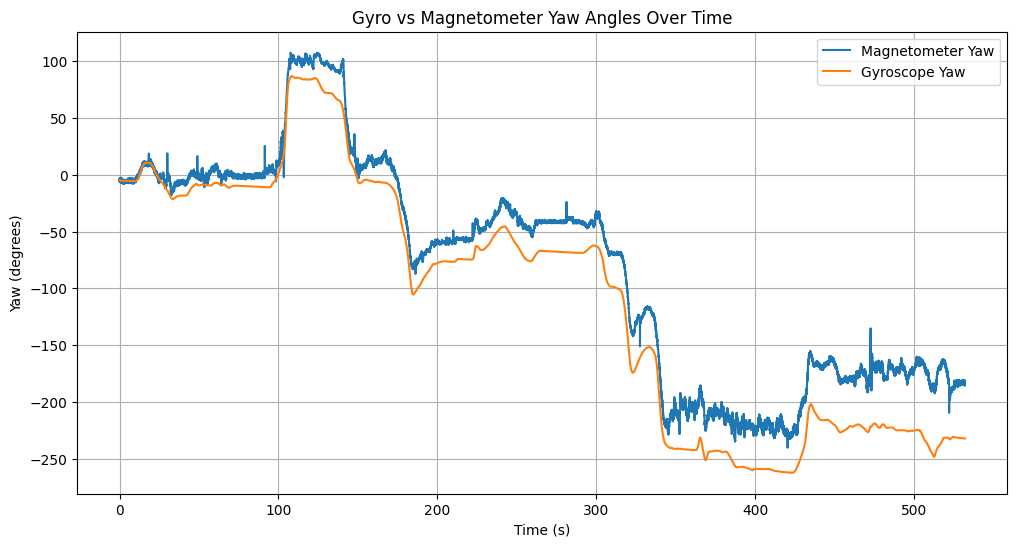

In [207]:
initial_yaw = np.average(yaw_corrected_degrees[0:40])
yaw_gyro = cumulative_trapezoid(-gyro_z,dx=0.025,initial=0) 
yaw_gyro_degrees = np.degrees(yaw_gyro) 
yaw_gyro_degrees = yaw_gyro_degrees + [initial_yaw]*len(yaw_gyro_degrees)

plt.figure(figsize=(12, 6))
plt.plot(imu_timestamps[1:], yaw_corrected_degrees[1:], label='Magnetometer Yaw')
plt.plot(imu_timestamps[1:], yaw_gyro_degrees[1:], label='Gyroscope Yaw')
plt.title('Gyro vs Magnetometer Yaw Angles Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Yaw (degrees)')
plt.legend()
plt.grid()
plt.savefig("gyrovsmag.png", format="png")


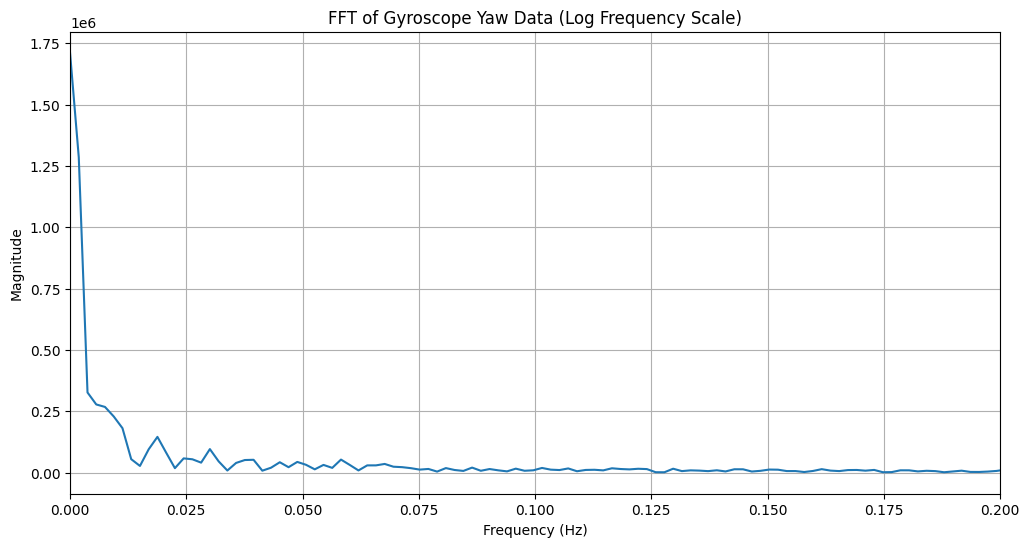

In [208]:
fs = 40  
cutoff = 0.1  # Desired cutoff frequency of the filter, Hz
n = len(yaw_corrected_degrees)
f = np.fft.fftfreq(n, d=1/fs)
fft_values = np.fft.fft(yaw_corrected_degrees)

plt.figure(figsize=(12, 6))
plt.plot(f[:n//2], np.abs(fft_values[:n//2]))  
plt.title('FFT of Gyroscope Yaw Data (Log Frequency Scale)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0,0.2)
plt.grid(True)
plt.show()

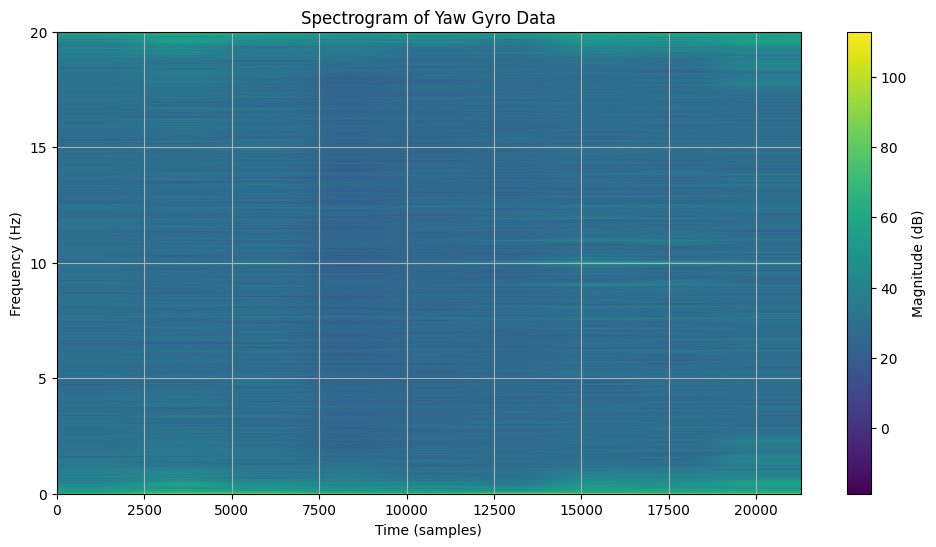

In [209]:
fs = 40  # Sampling frequency (Hz)
overlap = 0.5  # 50% overlap
window_size = 4096  # Size of the window

# Generate synthetic yaw_gyro_degrees data for demonstration
n = len(yaw_gyro_degrees)
n_windows = int((n - window_size) / (window_size * (1 - overlap))) + 1

# Store the FFT results
frequencies = np.fft.fftfreq(window_size, d=1/fs)
fft_results = np.zeros((n_windows, window_size), dtype=complex)

# Perform overlapping FFTs
for i in range(n_windows):
    start = int(i * window_size * (1 - overlap))
    end = start + window_size
    if end > n:  # Make sure we don't go out of bounds
        break
    windowed_signal = yaw_corrected_degrees[start:end] * signal.get_window('hann', window_size)
    fft_results[i] = np.fft.fft(windowed_signal)

# Calculate the magnitude of the FFT results
magnitude = np.abs(fft_results)

# Plotting the spectrogram
plt.figure(figsize=(12, 6))
plt.imshow(20 * np.log10(magnitude.T), aspect='auto', origin='lower', 
           extent=[0, n, 0, fs/2])
plt.colorbar(label='Magnitude (dB)')
plt.title('Spectrogram of Yaw Gyro Data')
plt.xlabel('Time (samples)')
plt.ylabel('Frequency (Hz)')
plt.yticks(np.arange(0, fs/2 + 1, 5))  # Customize y-ticks as needed
plt.grid()
plt.show()

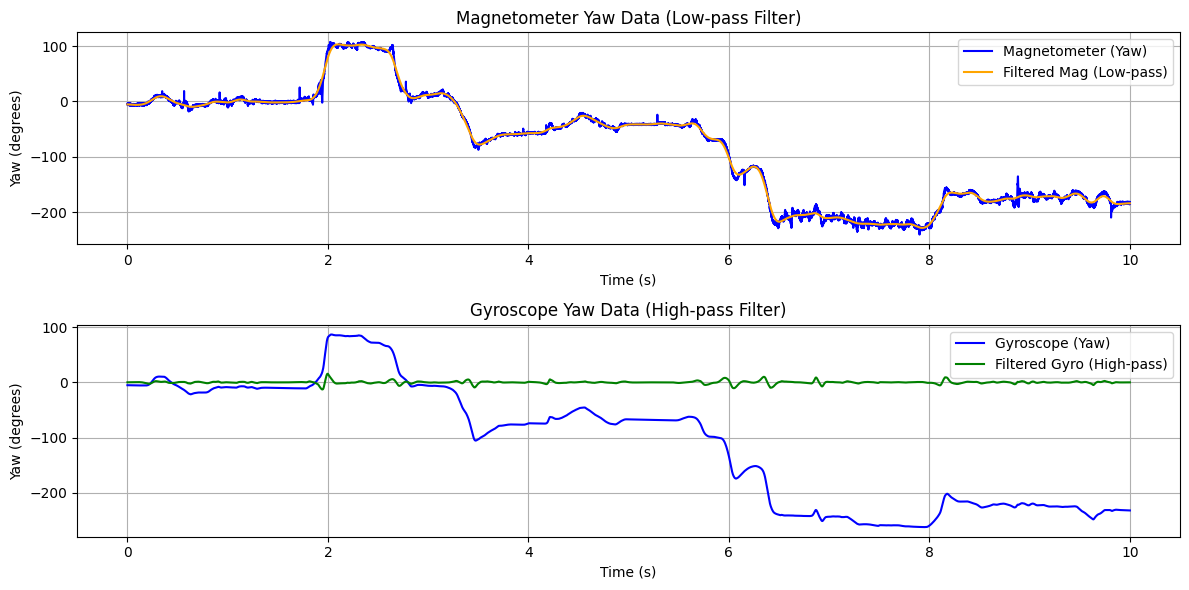

In [210]:

fs = 40  # Sampling frequency (Hz)
low_cutoff = 0.075  # Cutoff for the low-pass filter (Hz)
high_cutoff = 0.075  # Cutoff for the high-pass filter (Hz)

b_low, a_low = signal.butter(2, low_cutoff / (0.5 * fs), btype='lowpass')
b_high, a_high = signal.butter(2, high_cutoff / (0.5 * fs), btype='highpass', analog=False)

filtered_mag_yaw = signal.filtfilt(b_low, a_low, yaw_corrected_degrees)

filtered_gyro_yaw = signal.filtfilt(b_high, a_high, yaw_gyro_degrees) 
# filtered_gyro_yaw = filtered_gyro_yaw - [filtered_gyro_yaw[0]]*len(filtered_gyro_yaw)
plt.figure(figsize=(12, 6))

# Magnetometer plot (Low-pass filter)
plt.subplot(2, 1, 1)
plt.plot(np.linspace(0, 10, len(yaw_corrected_degrees)), yaw_corrected_degrees, label='Magnetometer (Yaw)', color='blue')
plt.plot(np.linspace(0, 10, len(filtered_mag_yaw)), filtered_mag_yaw, label='Filtered Mag (Low-pass)', color='orange')
plt.title('Magnetometer Yaw Data (Low-pass Filter)')
plt.xlabel('Time (s)')
plt.ylabel('Yaw (degrees)')
plt.legend()
plt.grid()

# Gyroscope plot (High-pass filter)
plt.subplot(2, 1, 2)
plt.plot(np.linspace(0, 10, len(yaw_gyro_degrees)), yaw_gyro_degrees, label='Gyroscope (Yaw)', color='blue')
plt.plot(np.linspace(0, 10, len(filtered_gyro_yaw)), filtered_gyro_yaw, label='Filtered Gyro (High-pass)', color='green')
plt.title('Gyroscope Yaw Data (High-pass Filter)')
plt.xlabel('Time (s)')
plt.ylabel('Yaw (degrees)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


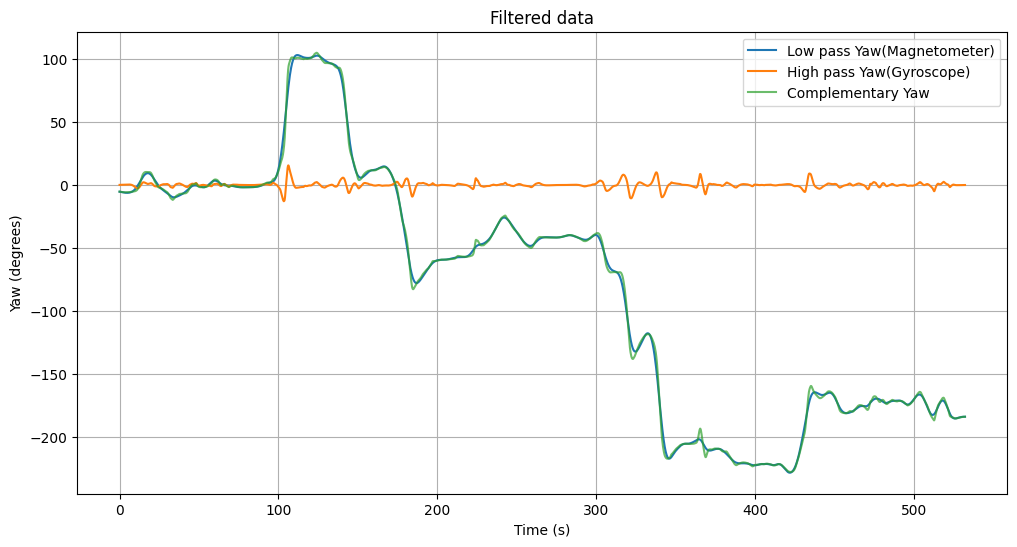

In [211]:

alpha = 0.01
low_pass_angles = 0.00*(filtered_gyro_yaw)+(1-0.00)*filtered_mag_yaw
high_pass_angles = 1*(filtered_gyro_yaw)+(1-1)*filtered_mag_yaw
complementary_angles = filtered_gyro_yaw+filtered_mag_yaw

plt.figure(figsize=(12, 6))
plt.plot(imu_timestamps[1:], low_pass_angles[1:], label='Low pass Yaw(Magnetometer)')
plt.plot(imu_timestamps[1:], high_pass_angles[1:], label='High pass Yaw(Gyroscope)')
plt.plot(imu_timestamps[1:], complementary_angles[1:], label='Complementary Yaw', alpha = 0.7)
# plt.plot(imu_timestamps,-np.unwrap(yaws), label='raw Yaw', alpha = 0.7)
plt.title('Filtered data')
plt.xlabel('Time (s)')
plt.ylabel('Yaw (degrees)')
plt.legend()
plt.grid()
plt.savefig("compfilt.png", format="png")

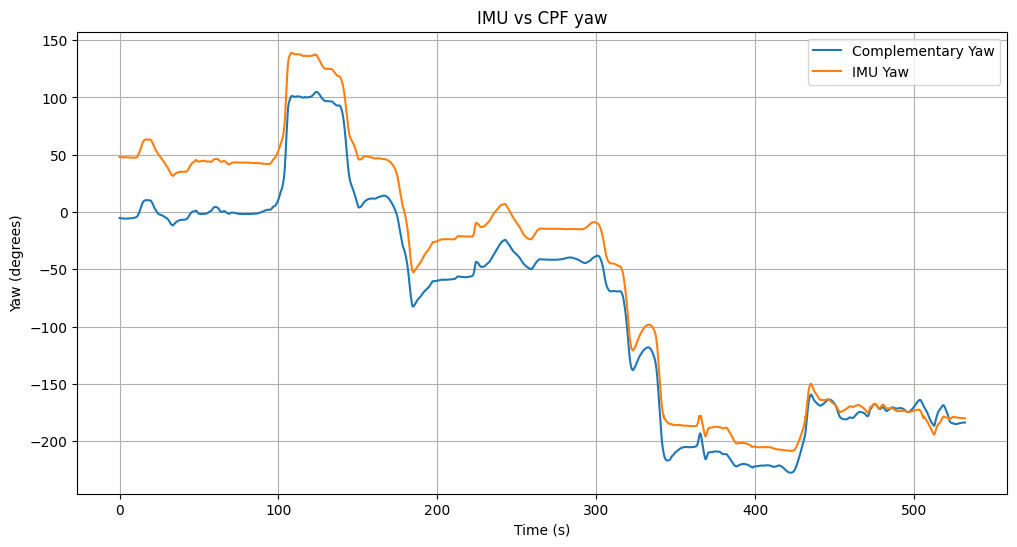

In [212]:
plt.figure(figsize=(12, 6))
# plt.plot(imu_timestamps[1:], low_pass_angles[1:], label='Low pass Yaw(Magnetometer)')
# plt.plot(imu_timestamps[1:], high_pass_angles[1:], label='IMU Yaw')
plt.plot(imu_timestamps[1:], complementary_angles[1:], label='Complementary Yaw')
plt.plot(imu_timestamps,-np.unwrap(yaws), label='IMU Yaw')
plt.title('IMU vs CPF yaw')
plt.xlabel('Time (s)')
plt.ylabel('Yaw (degrees)')
plt.legend()
plt.grid()
plt.savefig("cpfvsimu.png", format="png")

In [213]:
print(yaws[0]-yaws[-1])
print(complementary_angles[0]-complementary_angles[-1])

130.07100000000003
178.52271277420894


# Forward velocity

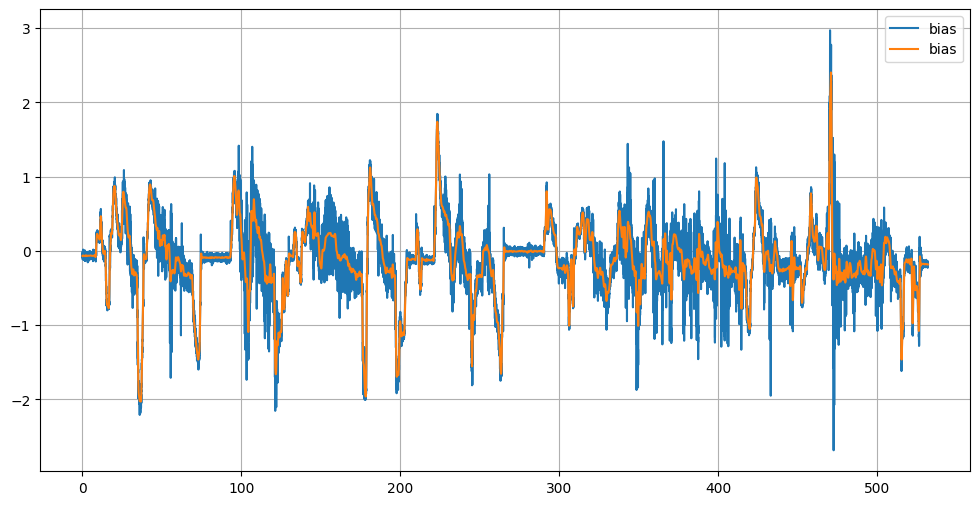

In [214]:
fs = 40
low_cutoff = 0.005   # Low cutoff frequency (Hz)
high_cutoff = 1  # High cutoff frequency (Hz)

# Normalize the cutoff frequencies by the Nyquist frequency
nyquist = 0.5 * fs
low = low_cutoff / nyquist
high = high_cutoff / nyquist

# Design the bandpass filter
b_band, a_band = signal.butter(3, high, btype='low')

# Apply the bandpass filter
filtered_accel_x = signal.filtfilt(b_band, a_band, accel_x)

# start_index = 10653
# end_index = 11733

# # Create a new list with the specified range modified
# filtered_accel_x = [
#     (filtered_accel_x[i] - 0.1173 if start_index <= i < end_index else filtered_accel_x[i])
#     for i in range(len(filtered_accel_x))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
# ]

filtered_accel_x = np.array(filtered_accel_x)
plt.figure(figsize=(12, 6))
plt.plot(imu_timestamps, accel_x, label='bias')
plt.plot(imu_timestamps, filtered_accel_x, label='bias')
plt.legend()
plt.grid()
plt.show()



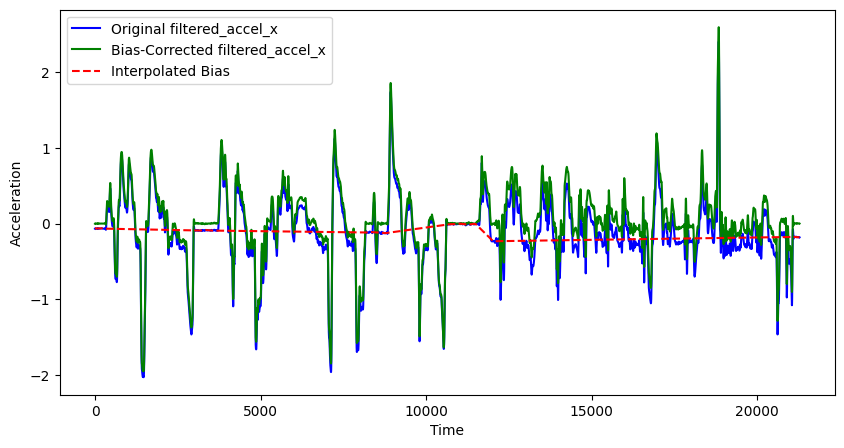

In [224]:
window_size = 40  # Adjust based on data frequency
std_threshold = 0.0015  # Set based on error tolerance

# Calculate rolling standard deviation
rolling_std = np.array([np.std(filtered_accel_x[i:i+window_size]) for i in range(len(filtered_accel_x) - window_size)])

# Identify stationary points
stationary_indices = np.where(rolling_std < std_threshold)[0] + window_size // 2  # Offset to center window

# Group stationary points into contiguous periods
stationary_periods = np.split(stationary_indices, np.where(np.diff(stationary_indices) > 1)[0] + 1)

# Calculate the bias for each stationary period
bias_values = []
bias_positions = []
for period in stationary_periods:
    if len(period) > 0:  # Ensure non-empty
        bias = np.mean(filtered_accel_x[period])  # Mean bias for this stationary segment
        bias_values.append(bias)
        bias_positions.append(period[len(period) // 2])  # Use middle point of period for position

# Interpolate bias across the entire dataset
interpolated_bias = np.interp(np.arange(len(filtered_accel_x)), bias_positions, bias_values)

# Correct the data by subtracting the interpolated bias
corrected_accel_x = filtered_accel_x - interpolated_bias

# Plot original, corrected filtered_accel_x, and interpolated bias
plt.figure(figsize=(10, 5))
plt.plot(filtered_accel_x, label='Original filtered_accel_x', color='blue')
plt.plot(corrected_accel_x, label='Bias-Corrected filtered_accel_x', color='green')
plt.plot(interpolated_bias, label='Interpolated Bias', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.legend()
plt.show()

In [216]:
def cumulative_trapezoid_integration(data, dx):
    
    cumulative_integral = np.zeros_like(data)

    for i in range(1, len(data)):
        # Trapezoidal rule: (data[i-1] + data[i]) / 2 * dx
        trapezoid_area = (data[i-1] + data[i]) / 2 * dx
        cumulative_integral[i] = cumulative_integral[i-1] + trapezoid_area
        if cumulative_integral[i]<0 or i in stationary_indices:
            cumulative_integral[i] = 0

    return cumulative_integral

In [217]:
# overall_accel = [np.sqrt(x**2 + y**2) for x, y in zip(accel_x, accel_y)]


# imu_forward_velocity = cumulative_trapezoid(corrected_accel_x,dx=0.025,initial=0)

# corrected_accel_x +=0.015
# for x in stationary_indices:
#     corrected_accel_x[x] = 0

imu_forward_velocity = cumulative_trapezoid_integration(corrected_accel_x,0.025)

gps_forward_velocity = []

# Loop through consecutive UTM points
for i in range(1, len(utm_easting)):
    # Extract UTM coordinates
    x1, y1 = utm_easting[i-1], utm_northing[i-1]
    x2, y2 = utm_easting[i], utm_northing[i]

    # Compute the displacement in easting and northing
    delta_x = x2 - x1
    delta_y = y2 - y1

    # Compute the Euclidean distance (displacement)
    delta_d = np.sqrt(delta_x**2 + delta_y**2)

    # Compute the time difference
    delta_t = gps_timestamps[i] - gps_timestamps[i-1]

    if delta_t > 0:
        # Compute the forward velocity
        velocity = delta_d / delta_t
    else:
        # In case of zero or negative time difference
        velocity = 0

    # Append the velocity to the list
    gps_forward_velocity.append(velocity)




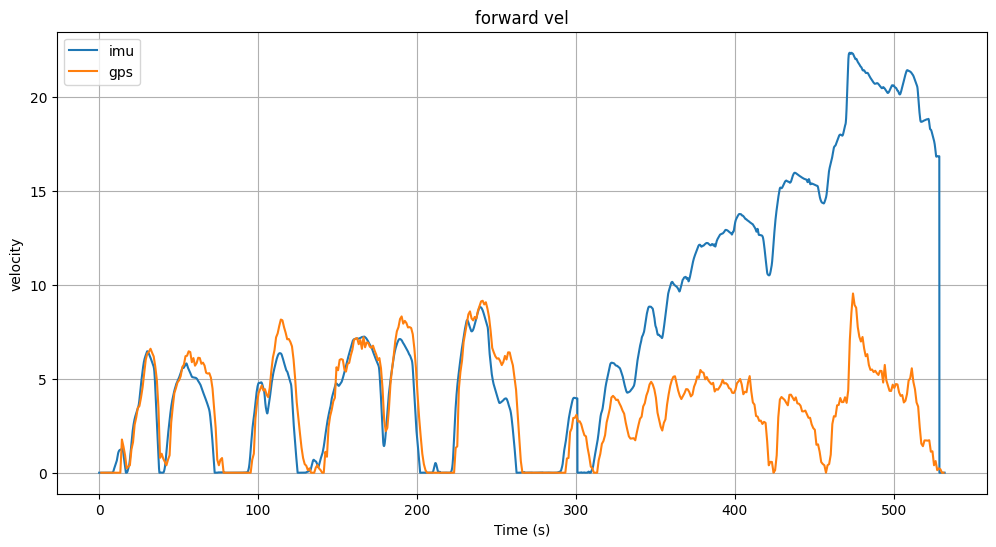

In [218]:
# low_cutoff = 0.02  # Low cutoff frequency (Hz)
# high_cutoff = 1  # High cutoff frequency (Hz)

# # Normalize the cutoff frequencies with the Nyquist frequency
# nyquist = 0.5 * fs
# low = low_cutoff / nyquist
# high = high_cutoff / nyquist

# # Design the Butterworth bandpass filter
# b_accel, a_accel = signal.butter(2, [low, high], btype='band')

# # Apply the filter to your forward velocity data
# filtered_imu_forward_velocity = signal.filtfilt(b_accel, a_accel, imu_forward_velocity)

# slope, intercept, r_value, p_value, std_err = linregress(imu_timestamps, imu_forward_velocity)

# # Calculate the linear trend
# linear_trend = slope*1.02 * imu_timestamps

# # Shift the data to remove the slope
# adjusted_data = imu_forward_velocity - linear_trend

# x_values = [0, 500]  # Starting from the origin to some x value
# y_values = [slope * x for x in x_values]  # Calculate y values using the slope


# imu_forward_velocity= imu_forward_velocity + [gps_forward_velocity[1]]*len(imu_forward_velocity)
plt.figure(figsize=(12, 6))
plt.plot(imu_timestamps, imu_forward_velocity, label='imu')
plt.plot(gps_timestamps[1:], gps_forward_velocity, label='gps')
# plt.plot(x_values, y_values, label=f'Line with slope {slope}', color='blue')

plt.title('forward vel')
plt.xlabel('Time (s)')
plt.ylabel('velocity')
plt.legend()
plt.grid()
plt.show()


# Dead reckoning

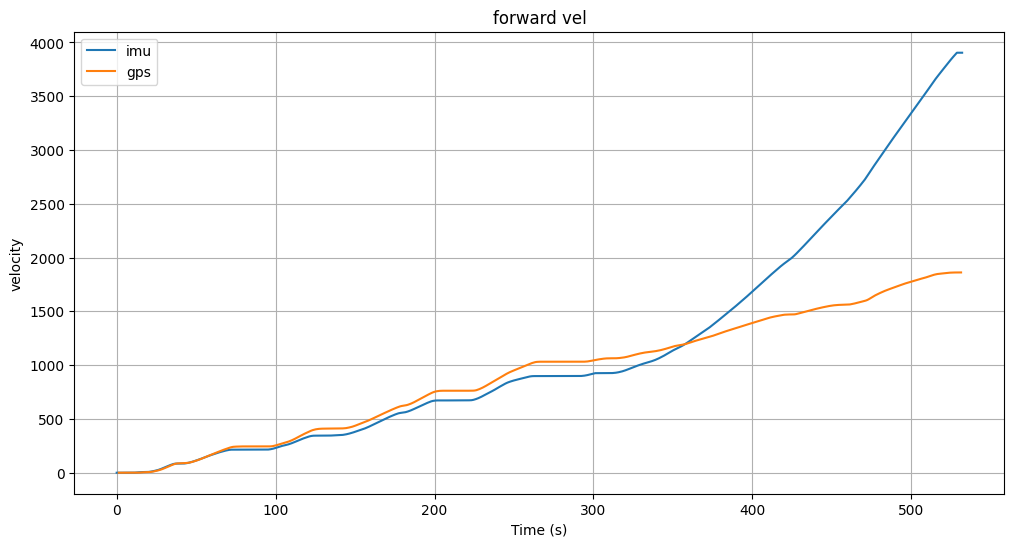

In [219]:
imu_disp = cumulative_trapezoid(imu_forward_velocity,dx=0.025,initial=0)
gps_disp = cumulative_trapezoid(gps_forward_velocity,dx=1,initial=0)
plt.figure(figsize=(12, 6))
plt.plot(imu_timestamps, imu_disp, label='imu')
plt.plot(gps_timestamps[1:], gps_disp, label='gps')
plt.title('forward vel')
plt.xlabel('Time (s)')
plt.ylabel('velocity')
plt.legend()
plt.grid()
plt.show()

-0.33479486116138985
[   3    6    1    0    2    7    1    4    6    1    3    2    3    3
    3    6    1    2    4    1    5    2    6    3    6    5    5    4
    3    4    5    4    4    1    4    9   10    5    8    7    8    4
    4    5    5    6    8    9   11    7    9   10   13    6   14   17
   14   18    7   18   13    8   14   17   18   23   19   24   23   21
   28   23   36   34   32   42   30   44   49   52   69   62   62   81
   74   93  111  153  154  191  235  291  362  409  537  682  943 1305
 1878 2300 2135 1706 1274  884  617  436  335  282  219  175  180  145
  138  101   93   80   75   65   62   44   43   41   36   31   40   37
   35   33   33   27   28   30   17   10   21   23   19    9   19    8
   11   15   11   13    7    9    9   13   10   15   13   10    7    8
    7   13    4    5    9    3    1   11    3   10    5    9    3    7
    4    8    7    1    3    9    6    7    2    5    2    5    6    3
    2    3    0    0    2    2    2    1    1    3    7 

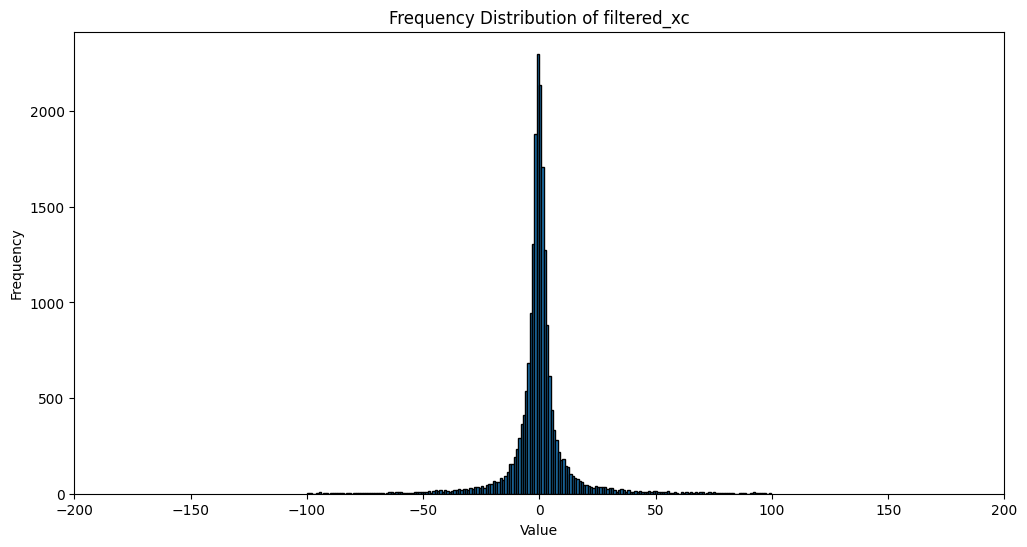

In [220]:
def remove_outliers(data, threshold=2):
    mean = sum(data) / len(data)
    std_dev = (sum((x - mean) ** 2 for x in data) / len(data)) ** 0.5
    
    return [x if abs(x - mean) < threshold * std_dev else mean for x in data]

angular_accel = []

# Calculate acceleration between each consecutive pair of points
for i in range(len(gyro_z) - 1):
    dv = gyro_z[i + 1] - gyro_z[i]         # Change in velocity
    dt = imu_timestamps[i + 1] - imu_timestamps[i]                   # Change in time
    a = dv / dt if dt != 0 else 0       # Prevent division by zero
    angular_accel.append(a)

squared_omega = [num ** 2 for num in gyro_z]

squared_omega_integral = cumulative_trapezoid(squared_omega,dx=0.025,initial=0)

xc = [(yodotdot-(w*xodot))/(wdot+(integ*w)) for yodotdot,w,xodot,wdot,integ in zip(accel_y,gyro_z,imu_forward_velocity,angular_accel,squared_omega_integral)]
# low_cutoff = 0.1

# b_low, a_low = signal.butter(2, low_cutoff / (0.5 * fs), btype='lowpass')
# filtered_xc = signal.filtfilt(b_low, a_low, xc)
filtered_xc = [x for x in xc if abs(x)<100]
print(np.median(xc))

# low_cutoff = 0.2

# b_low, a_low = signal.butter(2, low_cutoff / (0.5 * fs), btype='lowpass')
# filtered_xc2 = signal.filtfilt(b_low, a_low, filtered_xc)

hist, bins = np.histogram(filtered_xc, bins=200)

print(hist)
# Plot the histogram using Matplotlib
plt.figure(figsize=(12, 6))
plt.hist(filtered_xc, bins=200, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xlim(-200,200)
plt.title('Frequency Distribution of filtered_xc')
plt.show()


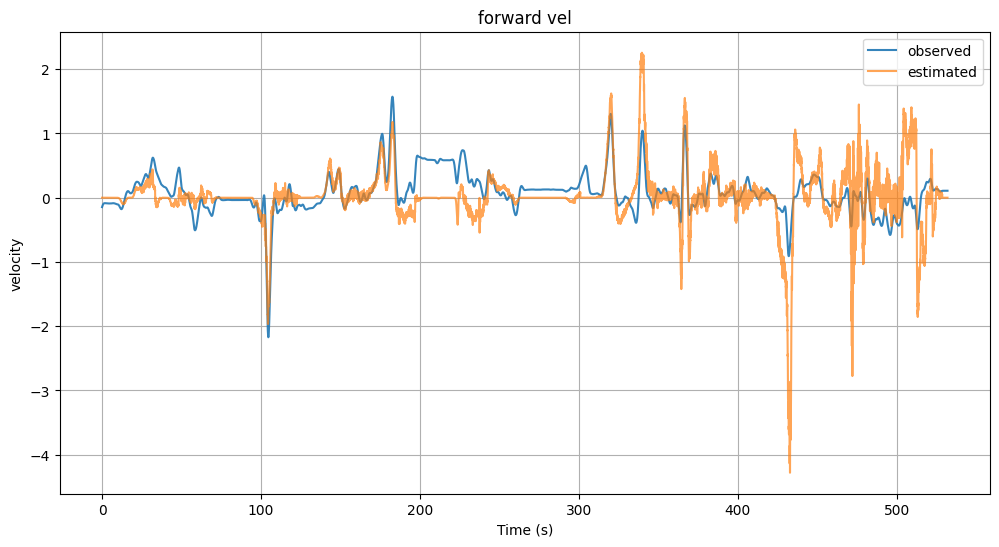

In [221]:
accel_y_estimated = [a * b for a, b in zip(gyro_z[1:], imu_forward_velocity)]
low_cutoff = 0.3

b_low, a_low = signal.butter(2, low_cutoff / (0.5 * fs), btype='lowpass')
filtered_accel_y = signal.filtfilt(b_low, a_low, accel_y)

plt.figure(figsize=(12, 6))
plt.plot(imu_timestamps, filtered_accel_y, label='observed', alpha = 0.9)
plt.plot(imu_timestamps[1:], accel_y_estimated, label='estimated', alpha = 0.7)
plt.title('forward vel')
plt.xlabel('Time (s)')
plt.ylabel('velocity')
plt.legend()
plt.grid()
plt.show()


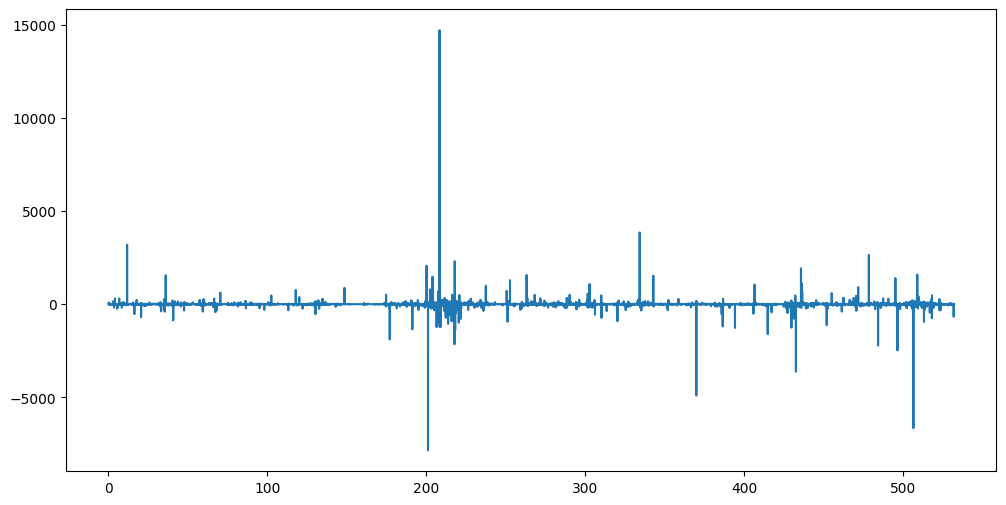

-0.6352743618649811


In [222]:
angular_accel = []

# Calculate acceleration between each consecutive pair of points
for i in range(len(gyro_z) - 1):
    dv = gyro_z[i + 1] - gyro_z[i]         # Change in velocity
    dt = imu_timestamps[i + 1] - imu_timestamps[i]                   # Change in time
    a = dv / dt if dt != 0 else 0       # Prevent division by zero
    angular_accel.append(a)
    
error = filtered_accel_y[1:] - accel_y_estimated
xc = [a/b for a, b in zip(error, angular_accel) if b!=0]
plt.figure(figsize=(12, 6))
plt.plot(imu_timestamps[5:],xc)
plt.show()

print(np.average(xc))


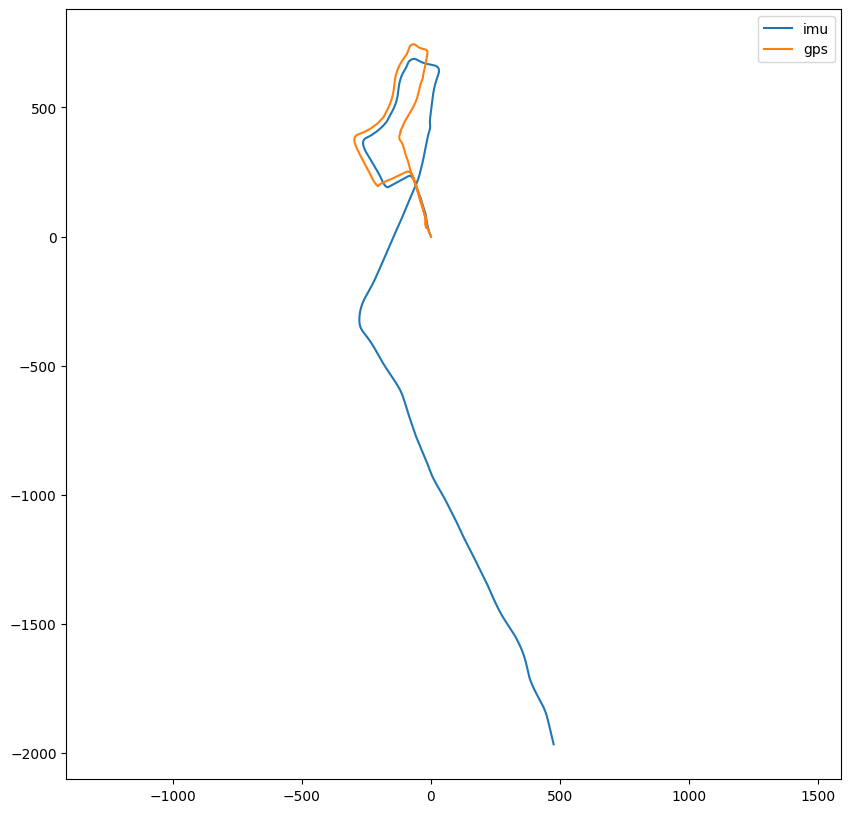

In [223]:
ve = [a*np.cos(np.radians(108+b)) for a, b in zip(imu_forward_velocity, complementary_angles)]
vn = [a*np.sin(np.radians(108+b)) for a, b in zip(imu_forward_velocity, complementary_angles)]

xe = cumulative_trapezoid(ve,dx = 0.025, initial=0)
xn = cumulative_trapezoid(vn,dx = 0.025, initial=0)

utm_easting = [x-utm_easting[0] for x in utm_easting]
utm_northing = [x-utm_northing[0] for x in utm_northing]


plt.figure(figsize=(10, 10))
plt.plot(xe,xn,label = 'imu')
plt.plot(utm_easting,utm_northing, label = 'gps')
plt.axis('equal')
plt.legend()
plt.show()

# print(np.average(xc))

